# Train YOLO and a Segmentation Model for road markings on Images from self-generated Data

In [ ]:
%pip install opencv-python ultralytics

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Generate Dataset by splitting video into frames

In [ ]:
def preprocess(image, dims=(512, 512)):
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    # crop image to a centered square
    min_dim = min(image.shape[0], image.shape[1])
    start_x = (image.shape[1] - min_dim) // 2
    start_y = (image.shape[0] - min_dim) // 2
    image = image[start_y:start_y+min_dim, start_x:start_x+min_dim]

    image = cv2.resize(image, dims)
    return image

In [ ]:
input('Are you sure you want to regenerate the frames? Press Enter to continue...')
print()

videos_path = 'data/traffic-signs-and-road-markings'
video_names = ['video1.mp4', 'video2.mp4']
sampling_rate = 20
output_path = 'data/traffic-signs-and-road-markings/frames'

if os.path.exists(output_path):
    print('Deleting existing frames...')
    for file_name in os.listdir(output_path):
        os.remove(os.path.join(output_path, file_name))
else:
    print('Creating output directory...')
    os.makedirs(output_path, exist_ok=True)

print('Extracting frames...')
for video_name in video_names:
    video_path = os.path.join(videos_path, video_name)
    capture = cv2.VideoCapture(video_path)
    fps = capture.get(cv2.CAP_PROP_FPS)
    width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f'Video: {video_name}')
    print(f'FPS: {fps}')
    print(f'Size: {width}x{height}')

    frame_count = 0
    saved_frames = 0
    while True:
        success, frame = capture.read()
        print(f'Saved frames: {saved_frames}', end='\r')
        if not success:
            break
        
        if frame_count % sampling_rate == 0:
            saved_frames += 1
            cv2.imwrite(os.path.join(output_path, f'{video_name.split('.')[0]}_{str(saved_frames).zfill(3)}.jpg'), preprocess(frame))
                
        frame_count += 1
    
    print(f'Successfully saved {saved_frames} frames from video {video_name} ({frame_count} frames in total)')
    print()



### Load data

In [3]:
import json
import re

dataset_path = 'data/traffic-signs-and-road-markings/sr-20-annotated'
images_path = os.path.join(dataset_path, 'images')

with open(os.path.join(dataset_path, 'localization-classes.txt'), 'r') as file:
    localization_classes = file.read().splitlines()

with open(os.path.join(dataset_path, 'segmentation-classes.txt'), 'r') as file:
    segmentation_classes = file.read().splitlines()

with open(os.path.join(dataset_path, 'localization-classes-german.txt'), 'r', encoding='utf-8') as file:
    localization_classes_german = file.read().splitlines()

with open(os.path.join(dataset_path, 'segmentation-classes-german.txt'), 'r', encoding='utf-8') as file:
    segmentation_classes_german = file.read().splitlines()

print('Localization classes:', localization_classes)
print('Segmentation classes:', segmentation_classes)

with open(os.path.join(dataset_path, 'localization.json'), 'r') as file:
    localization_data_list = json.load(file)

with open(os.path.join(dataset_path, 'segmentation.json'), 'r') as file:
    segmentation_data_list = json.load(file)

localization_data = {}
for entry in localization_data_list:
    image_name = entry['data']['image'].split('%5C')[-1]
    localization_data[image_name] = entry

segmentation_data = {}
for entry in segmentation_data_list:
    image_name = entry['data']['image'].split('%5C')[-1]
    segmentation_data[image_name] = entry

image_width = 512
image_height = 512
             
data = []

for image_name in os.listdir(images_path):
    image_path = os.path.join(images_path, image_name)
    image = plt.imread(image_path)
    
    if image.shape[0] != image_height or image.shape[1] != image_width:
        print(f'Invalid image size: {image.shape} (expected: {image_height}x{image_width})')
        continue
    
    localization = localization_data[image_name]
    bounding_boxes = []
    for annotation in localization['annotations']:
        result = annotation['result']
        if not result:
            continue

        for entry in result:
            value = entry['value']
            label = value['rectanglelabels'][0]
            if label not in localization_classes:
                print(f'Unknown localization class: {label}')
                continue
                
            class_index = localization_classes.index(label)
            x_center = (value['x'] + value['width'] / 2) / 100
            y_center = (value['y'] + value['height'] / 2) / 100
            width = value['width'] / 100
            height = value['height'] / 100
            bounding_boxes.append([class_index, x_center, y_center, width, height])

    # create binary mask for each segmentation class from the polygon data
    segmentation = segmentation_data[image_name]
    masks = np.zeros((len(segmentation_classes), image_width, image_height), dtype=np.uint8)
    for annotation in segmentation['annotations']:
        result = annotation['result']
        if not result:
            continue

        for entry in result:
            value = entry['value']
            label = value['polygonlabels'][0]
            if label not in segmentation_classes:
                print(f'Unknown segmentation class: {label}')
                continue

            class_index = segmentation_classes.index(label)
            points = value['points']
            # points are given as percentages of the image size
            polygon = np.array([[int(p[0] / 100 * image_width), int(p[1] / 100 * image_height)] for p in points], dtype=np.int32)
            cv2.fillPoly(masks[class_index], [polygon], 1)

    data.append({
        'name': image_name,
        'image': image,
        'bounding_boxes': bounding_boxes,
        'segmentation_masks': masks
    })

# sort by frame because i had unlucky naming when labeling the data for the first time
data.sort(key=lambda x: [int(n) if n.isdigit() else n for n in re.split(r'(\d+)', x['name'])])

print([d['name'] for d in data])
print(f'Successfully loaded {len(data)} data entries')


Localization classes: ['green-light', 'red-light', 'speed-limit-10', 'speed-limit-20', 'stop-sign']
Segmentation classes: ['road', 'traffic-sign']
['video1_1.jpg', 'video1_2.jpg', 'video1_3.jpg', 'video1_4.jpg', 'video1_5.jpg', 'video1_6.jpg', 'video1_7.jpg', 'video1_8.jpg', 'video1_9.jpg', 'video1_10.jpg', 'video1_11.jpg', 'video1_12.jpg', 'video1_13.jpg', 'video1_14.jpg', 'video1_15.jpg', 'video1_16.jpg', 'video1_17.jpg', 'video1_18.jpg', 'video1_19.jpg', 'video1_20.jpg', 'video1_21.jpg', 'video1_22.jpg', 'video1_23.jpg', 'video1_24.jpg', 'video1_25.jpg', 'video1_26.jpg', 'video1_27.jpg', 'video1_28.jpg', 'video1_29.jpg', 'video1_30.jpg', 'video1_31.jpg', 'video1_32.jpg', 'video1_33.jpg', 'video1_34.jpg', 'video1_35.jpg', 'video1_36.jpg', 'video1_37.jpg', 'video1_38.jpg', 'video2_1.jpg', 'video2_2.jpg', 'video2_3.jpg', 'video2_4.jpg', 'video2_5.jpg', 'video2_6.jpg', 'video2_7.jpg', 'video2_8.jpg', 'video2_9.jpg', 'video2_10.jpg', 'video2_11.jpg', 'video2_12.jpg', 'video2_13.jpg', 'vi

### Visualization

In [4]:
from matplotlib.patches import Patch

colors = [
    [0.1, 0.2, 0.5],
    [0.8, 0.1, 0.1],
    [0.1, 0.6, 0.1],
    [0.6, 0.1, 0.6],
    [0.1, 0.6, 0.6],
]

def show_overlayed_masks(ax: plt.axes, masks: list[np.ndarray]):
    surrounding_mask = np.ones((image_width, image_height), dtype=np.uint8)
    for mask in masks:
        surrounding_mask[mask == 1] = 0

    display_masks = [*masks, surrounding_mask]
    for i, mask in enumerate(display_masks):
        overlay = np.zeros((image_width, image_height, 4))
        overlay[mask == 1] = [*colors[i], 1]
        ax.imshow(overlay, alpha=0.3)
    
    legend_elements = [
        Patch(facecolor=[*colors[i], 0.6], label=[*segmentation_classes_german, 'Umgebung'][i]) for i in range(len(segmentation_classes) + 1)
    ]

    plt.legend(handles=legend_elements, loc='upper right', fontsize=6, title='Segmentierung', title_fontsize=8)

def show_bounding_boxes(ax: plt.axes, bounding_boxes: list[list[float]]):
    for box in bounding_boxes:
        class_index, x_center, y_center, width, height = box
        x = (x_center - width / 2) * image_width
        y = (y_center - height / 2) * image_height
        rect = plt.Rectangle((x, y), width * image_width, height * image_height, linewidth=1, edgecolor=colors[class_index], facecolor='none')
        ax.add_patch(rect)
        ax.text(x + 5, y - 10, localization_classes_german[class_index], color='white', backgroundcolor=[c * 0.5 for c in colors[class_index]], fontsize=6)

def save_annotated_frames(data: list[dict], folder: str = 'frames', overwrite: bool = False, show_masks: bool = True, show_boxes: bool = True):    
    folder_path = os.path.join('media', folder)
    if os.path.exists(folder_path):
        if not overwrite:
            raise FileExistsError(f'Folder {folder_path} already exists')
        
        for file_name in os.listdir(folder_path):
            os.remove(os.path.join(folder_path, file_name))
    else:
        os.makedirs(folder_path, exist_ok=True)

    for i, entry in enumerate(data):
        fig, ax = plt.subplots()
        ax.imshow(entry['image'])
        ax.axis('off')
        if show_masks:
            show_overlayed_masks(ax, entry['segmentation_masks'])
        if show_boxes:
            show_bounding_boxes(ax, entry['bounding_boxes'])
        frame_path = os.path.join(folder_path, f'frame_{i}.png')
        plt.savefig(frame_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        print(f'Saved frame {i}/{len(data)}', end='\r')

    print(f'Successfully saved {len(data)} frames')

def join_frames_to_video(source_path = 'media/frames', target_path = 'media', video_name = 'video', fps = 2, dims = (512, 512)):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_path = os.path.join(target_path, f'{video_name}.mp4')
    out = cv2.VideoWriter(video_path, fourcc, fps, dims, True)
    files = os.listdir(source_path)

    for i, file in enumerate(files):
        img = cv2.imread(os.path.join(source_path, file))
        if img is None:
            continue

        if img.shape[0] != dims[0] or img.shape[1] != dims[1]:
            img = cv2.resize(img, dims)
        
        out.write(img)
        print(f'Processed frame {i}/{len(files)}', end='\r')

    out.release()
    print(f'Video with {len(files)} frames saved successfully')

In [ ]:
save_annotated_frames(data, show_masks=True, show_boxes=True, overwrite=True)

In [ ]:
join_frames_to_video()

In [ ]:
entry = data[75]
fig, ax = plt.subplots()
ax.imshow(entry['image'])
ax.axis('off')
show_overlayed_masks(ax, entry['segmentation_masks'])
# show_bounding_boxes(ax, entry['bounding_boxes'])
# plt.savefig('media/Segmentierung_Beispiel.png', bbox_inches='tight', pad_inches=0)
plt.show()

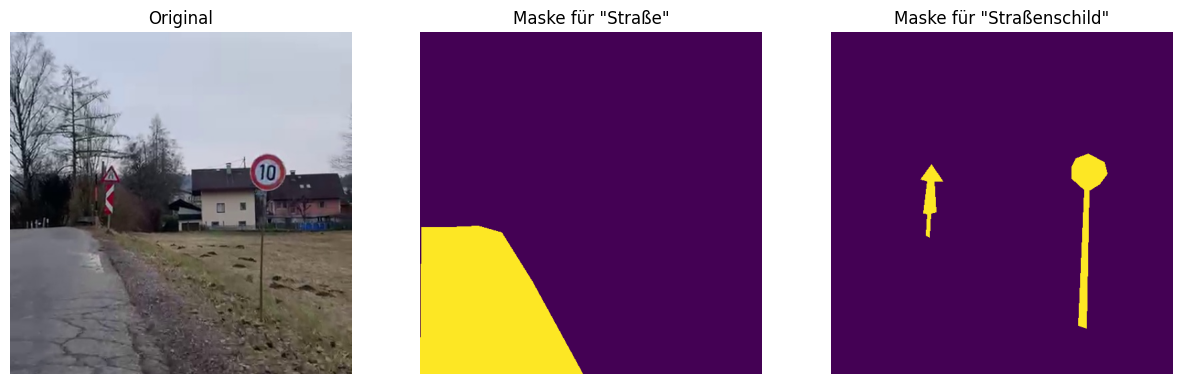

In [19]:
entry = data[75]
# 3 images side by side, original, mask 0, mask 1
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(entry['image'])
axs[0].axis('off')
axs[0].set_title('Original')
axs[1].imshow(entry['segmentation_masks'][0], cmap='viridis')
axs[1].set_title('Maske für "Straße"')
axs[1].axis('off')
axs[2].imshow(entry['segmentation_masks'][1], cmap='viridis')
axs[2].set_title('Maske für "Straßenschild"')
axs[2].axis('off')
plt.savefig('media/Segmentierungsmasken.png', bbox_inches='tight')
plt.show()

### Fine-tune Pretrained YOLO Model
https://docs.ultralytics.com/de/usage/python/\
https://pytorch.org/hub/ultralytics_yolov5/

In [ ]:
dataset_root = 'data/traffic-signs-and-road-markings'
dataset_path = os.path.join(dataset_root, 'yolo-with-images')

Convert dataset exported from Labelstudio to YOLO format

In [ ]:
import shutil
images_path = os.path.join(dataset_path, 'images')
labels_path = os.path.join(dataset_path, 'labels')

# split data into val and train
train_val_split = 0.8
images_names = os.listdir(images_path)
np.random.shuffle(images_names)
split_index = int(len(images_names) * train_val_split)
train_images_names = images_names[:split_index]
val_images_names = images_names[split_index:]

if os.path.exists(os.path.join(dataset_path, 'train')):
  shutil.rmtree(os.path.join(dataset_path, 'train'))
if os.path.exists(os.path.join(dataset_path, 'val')):
  shutil.rmtree(os.path.join(dataset_path, 'val'))

os.makedirs(os.path.join(dataset_path, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'val', 'labels'), exist_ok=True)

for image_name in train_images_names:
    shutil.copy(os.path.join(images_path, image_name), os.path.join(dataset_path, 'train', 'images'))
    shutil.copy(os.path.join(labels_path, image_name.replace('.jpg', '.txt')), os.path.join(dataset_path, 'train', 'labels'))

for image_name in val_images_names:
    shutil.copy(os.path.join(images_path, image_name), os.path.join(dataset_path, 'val', 'images'))
    shutil.copy(os.path.join(labels_path, image_name.replace('.jpg', '.txt')), os.path.join(dataset_path, 'val', 'labels'))

# generate dataset.yaml
dataset_yaml = f"""
train: ./train/images
val: ./val/images

nc: {len(localization_classes)}
names: {{"{', '.join(localization_classes)}"}}
"""

with open(os.path.join(dataset_path, 'dataset.yaml'), 'w') as file:
    file.write(dataset_yaml)
  
print('Successfully split data into train and val datasets and generated dataset.yaml')

In [ ]:
from ultralytics import YOLO

model = YOLO('models/yolov5su.pt')
model.train(data=os.path.join(dataset_path, 'dataset.yaml'), epochs=5)

Show results

In [ ]:
data_path = os.path.join(dataset_path, 'images')
for image_name in os.listdir(data_path):
    results = model.predict(source=os.path.join(data_path, image_name))
    plt.imshow(results[0].plot())
    plt.axis('off')
    plt.show()

Annotate Video with YOLO labels

In [ ]:
sampling_rate = 1
dims = (512, 512)
video_name = 'video1.mp4'
video_path = os.path.join(dataset_root, video_name)
capture = cv2.VideoCapture(video_path)
fps = capture.get(cv2.CAP_PROP_FPS)
width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

print(f'FPS: {fps}')
print(f'Size: {width}x{height}')

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_path = os.path.join(dataset_root, f'{video_name.split(".")[0]}_yolo.mp4')
out = cv2.VideoWriter(output_path, fourcc, int(fps / sampling_rate), dims, True)

frame_count = 0
saved_frames = 0
while True:
    success, frame = capture.read()
    if not success:
        break
    
    if frame_count % sampling_rate == 0:
        saved_frames += 1
        results = model.predict(source=preprocess(frame, dims), save=False)
        image = results[0].plot()
        out.write(image)
        print(f'Processed frames: {saved_frames}', end='\r')
       
    frame_count += 1
  
print('Successfully generated video')
out.release()

### Semantic segmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Modellaufbau
input_layer = layers.Input(shape=(512, 512, 3))

# Encoder: Convolutional Layers
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Decoder: Upsampling und Convolution
x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)

# Ausgangsschicht für 2 Masken
output_layer = layers.Conv2D(2, (1, 1), activation='sigmoid', padding='same')(x)

# Modell erstellen
model = models.Model(inputs=input_layer, outputs=output_layer)

# Modell kompilieren
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
train_val_split = 0.8
split_index = int(len(data) * train_val_split)
train_data = data[:split_index]
val_data = data[split_index:]

np.random.shuffle(train_data)
np.random.shuffle(val_data)

train_images = np.array([entry['image'] for entry in train_data])
train_masks = np.array([np.transpose(entry['segmentation_masks'], (1, 2, 0)) for entry in train_data])
val_images = np.array([entry['image'] for entry in val_data])
val_masks = np.array([np.transpose(entry['segmentation_masks'], (1, 2, 0)) for entry in val_data])

model.fit(train_images, train_masks, epochs=5, validation_data=(val_images, val_masks))